In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import metrics
import calendar
import xgboost as xgb

# Fare Price Prediction

### Data Loading


In [2]:
training = pd.read_csv('train_data_iitm.csv')
test = pd.read_csv('test_data_iitm.csv')
taxi_mapping = pd.read_csv('taxi_zone_mapping.csv')

In [3]:
training.shape

(60000, 12)

In [4]:
training.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge
0,2.0,2020-06-10 13:36:49,2020-06-10 13:51:08,1.0,2.73,1.0,N,224,148,2.0,12.00,2.5
1,NaN,2020-06-13 06:19:00,2020-06-13 06:37:00,NaN,11.58,NaN,NaN,56,42,NaN,28.81,0.0
2,2.0,2020-06-20 07:59:23,2020-06-20 08:05:39,1.0,2.05,1.0,N,79,68,2.0,8.00,2.5
3,1.0,2020-06-27 15:11:32,2020-06-27 15:15:02,1.0,1.40,1.0,N,236,75,1.0,6.00,2.5
4,1.0,2020-06-26 16:00:36,2020-06-26 16:02:28,1.0,0.60,1.0,N,186,90,2.0,4.00,2.5


In [5]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               54365 non-null  float64
 1   tpep_pickup_datetime   60000 non-null  object 
 2   tpep_dropoff_datetime  60000 non-null  object 
 3   passenger_count        54365 non-null  float64
 4   trip_distance          60000 non-null  float64
 5   RatecodeID             54365 non-null  float64
 6   store_and_fwd_flag     54365 non-null  object 
 7   PULocationID           60000 non-null  int64  
 8   DOLocationID           60000 non-null  int64  
 9   payment_type           54365 non-null  float64
 10  fare_amount            60000 non-null  float64
 11  congestion_surcharge   60000 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 5.5+ MB


In [6]:
training.isnull().sum()

VendorID                 5635
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          5635
trip_distance               0
RatecodeID               5635
store_and_fwd_flag       5635
PULocationID                0
DOLocationID                0
payment_type             5635
fare_amount                 0
congestion_surcharge        0
dtype: int64

In [7]:
training= training.dropna() 

In [8]:
training.pop('VendorID')

0        2.0
2        2.0
3        1.0
4        1.0
5        1.0
        ... 
59995    1.0
59996    2.0
59997    1.0
59998    2.0
59999    1.0
Name: VendorID, Length: 54365, dtype: float64

In [9]:
training.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge
0,2020-06-10 13:36:49,2020-06-10 13:51:08,1.0,2.73,1.0,N,224,148,2.0,12.0,2.5
2,2020-06-20 07:59:23,2020-06-20 08:05:39,1.0,2.05,1.0,N,79,68,2.0,8.0,2.5
3,2020-06-27 15:11:32,2020-06-27 15:15:02,1.0,1.40,1.0,N,236,75,1.0,6.0,2.5
4,2020-06-26 16:00:36,2020-06-26 16:02:28,1.0,0.60,1.0,N,186,90,2.0,4.0,2.5
5,2020-06-10 13:00:08,2020-06-10 13:13:58,1.0,4.00,1.0,N,137,236,1.0,15.0,2.5


### Trimming Data and throwing useless information out

In [10]:
training['pickup_datetime']=pd.to_datetime(training['tpep_pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
training['dropoff_datetime']=pd.to_datetime(training['tpep_dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
training['pickup_date']= training['pickup_datetime'].dt.date
training['pickup_day']=training['pickup_datetime'].apply(lambda x:x.day)
training['pickup_hour']=training['pickup_datetime'].apply(lambda x:x.hour)
training['pickup_day_of_week']=training['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
training['pickup_month']=training['pickup_datetime'].apply(lambda x:x.month)
training['pickup_year']=training['pickup_datetime'].apply(lambda x:x.year)
training['time'] = (training.dropoff_datetime - training.pickup_datetime) / pd.Timedelta(minutes=1)
training.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge,pickup_datetime,dropoff_datetime,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,time
0,2020-06-10 13:36:49,2020-06-10 13:51:08,1.0,2.73,1.0,N,224,148,2.0,12.0,2.5,2020-06-10 13:36:49,2020-06-10 13:51:08,2020-06-10,10,13,Wednesday,6,2020,14.316667
2,2020-06-20 07:59:23,2020-06-20 08:05:39,1.0,2.05,1.0,N,79,68,2.0,8.0,2.5,2020-06-20 07:59:23,2020-06-20 08:05:39,2020-06-20,20,7,Saturday,6,2020,6.266667
3,2020-06-27 15:11:32,2020-06-27 15:15:02,1.0,1.40,1.0,N,236,75,1.0,6.0,2.5,2020-06-27 15:11:32,2020-06-27 15:15:02,2020-06-27,27,15,Saturday,6,2020,3.500000
4,2020-06-26 16:00:36,2020-06-26 16:02:28,1.0,0.60,1.0,N,186,90,2.0,4.0,2.5,2020-06-26 16:00:36,2020-06-26 16:02:28,2020-06-26,26,16,Friday,6,2020,1.866667
5,2020-06-10 13:00:08,2020-06-10 13:13:58,1.0,4.00,1.0,N,137,236,1.0,15.0,2.5,2020-06-10 13:00:08,2020-06-10 13:13:58,2020-06-10,10,13,Wednesday,6,2020,13.833333


In [11]:
training['pickup_year'].value_counts()

2020    54364
2009        1
Name: pickup_year, dtype: int64

In [12]:
training['pickup_month'].value_counts()

6    54362
1        1
5        1
7        1
Name: pickup_month, dtype: int64

In [13]:
training['store_and_fwd_flag'].value_counts()

N    53933
Y      432
Name: store_and_fwd_flag, dtype: int64

In [14]:
training = training.drop(['tpep_pickup_datetime','tpep_dropoff_datetime','pickup_datetime','dropoff_datetime','pickup_date','pickup_day','pickup_month','pickup_year','payment_type'],axis = 1)

In [15]:
training['RatecodeID'].value_counts()

1.0     53357
2.0       610
5.0       264
4.0        66
3.0        62
99.0        6
Name: RatecodeID, dtype: int64

In [16]:
training.replace({'store_and_fwd_flag':{"N":0,"Y":1}}, inplace=True )

In [17]:
training.head()

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,congestion_surcharge,pickup_hour,pickup_day_of_week,time
0,1.0,2.73,1.0,0,224,148,12.0,2.5,13,Wednesday,14.316667
2,1.0,2.05,1.0,0,79,68,8.0,2.5,7,Saturday,6.266667
3,1.0,1.40,1.0,0,236,75,6.0,2.5,15,Saturday,3.500000
4,1.0,0.60,1.0,0,186,90,4.0,2.5,16,Friday,1.866667
5,1.0,4.00,1.0,0,137,236,15.0,2.5,13,Wednesday,13.833333


In [18]:
training.replace({'pickup_day_of_week':{"Sunday":0,"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6}}, inplace=True )

In [19]:
training['day_of_week_sin'] = np.sin(training['pickup_day_of_week'] * (2 * np.pi / 7))
training['day_of_week_cos'] = np.cos(training['pickup_day_of_week'] * (2 * np.pi / 7))

In [20]:
training.pop('pickup_day_of_week')
training.head()

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,congestion_surcharge,pickup_hour,time,day_of_week_sin,day_of_week_cos
0,1.0,2.73,1.0,0,224,148,12.0,2.5,13,14.316667,0.433884,-0.900969
2,1.0,2.05,1.0,0,79,68,8.0,2.5,7,6.266667,-0.781831,0.623490
3,1.0,1.40,1.0,0,236,75,6.0,2.5,15,3.500000,-0.781831,0.623490
4,1.0,0.60,1.0,0,186,90,4.0,2.5,16,1.866667,-0.974928,-0.222521
5,1.0,4.00,1.0,0,137,236,15.0,2.5,13,13.833333,0.433884,-0.900969


In [21]:
training.isnull().sum()

passenger_count         0
trip_distance           0
RatecodeID              0
store_and_fwd_flag      0
PULocationID            0
DOLocationID            0
fare_amount             0
congestion_surcharge    0
pickup_hour             0
time                    0
day_of_week_sin         0
day_of_week_cos         0
dtype: int64

## Trimming Test Data

In [22]:
test['tpep_pickup_datetime']=pd.to_datetime(test['tpep_pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test['tpep_dropoff_datetime']=pd.to_datetime(test['tpep_dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_hour']=test['tpep_pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['tpep_pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['time'] = (test.tpep_dropoff_datetime - test.tpep_pickup_datetime) / pd.Timedelta(minutes=1)
test =  test.drop(['tpep_pickup_datetime','tpep_dropoff_datetime','VendorID','payment_type'],axis = 1)
test.replace({'store_and_fwd_flag':{"N":0,"Y":1}}, inplace=True )
test.replace({'pickup_day_of_week':{"Sunday":0,"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6}}, inplace=True )
test['day_of_week_sin'] = np.sin(test['pickup_day_of_week'] * (2 * np.pi / 7))
test['day_of_week_cos'] = np.cos(test['pickup_day_of_week'] * (2 * np.pi / 7))
test = test.drop(['pickup_day_of_week'],axis = 1)
test.head()

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,congestion_surcharge,pickup_hour,time,day_of_week_sin,day_of_week_cos
0,1.0,1.66,1.0,0.0,48,90,2.5,18,5.683333,0.974928,-0.222521
1,3.0,1.50,1.0,0.0,48,246,2.5,23,7.000000,-0.781831,0.623490
2,1.0,1.90,1.0,0.0,237,234,2.5,12,7.166667,0.974928,-0.222521
3,1.0,0.27,1.0,0.0,170,170,2.5,9,2.550000,-0.781831,0.623490
4,2.0,4.06,1.0,0.0,186,238,2.5,18,16.800000,0.974928,-0.222521


## Splitting Data

In [23]:
X = training.drop('fare_amount',axis = 1)
Y = training['fare_amount']

In [24]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y,test_size = 0.2, random_state = 4)

## Linear Regression

In [25]:
lin_reg_model = LinearRegression()

In [26]:
lin_reg_model.fit(X_train,Y_train)

LinearRegression()

In [27]:
training_data_prediction = lin_reg_model.predict(X_train)

In [28]:
score_LR_train = metrics.r2_score(training_data_prediction,Y_train)
print(f"R2 Score: {score_LR_train}")
error_LR_train = metrics.mean_squared_error(training_data_prediction,Y_train)
print(f"Mean Squared Error: {error_LR_train}")

R2 Score: 0.5955034286791389
Mean Squared Error: 38.25868497600965


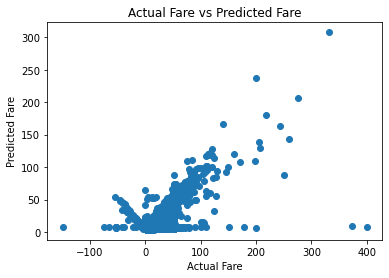

In [29]:
plt.scatter(Y_train,training_data_prediction)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual Fare vs Predicted Fare")
plt.show()

R2 Score: 0.7020139376829979
Mean Squared Error: 25.15227582066491


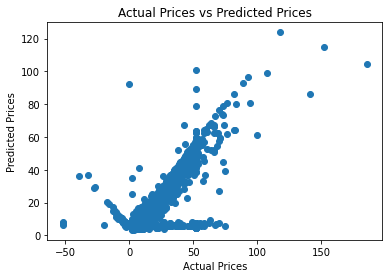

In [30]:
test_data_prediction = lin_reg_model.predict(X_valid)
score_LR_valid = metrics.r2_score(test_data_prediction,Y_valid)
print(f"R2 Score: {score_LR_valid}")
error_LR_valid = metrics.mean_squared_error(test_data_prediction,Y_valid)
print(f"Mean Squared Error: {error_LR_valid}")
plt.scatter(Y_valid,test_data_prediction)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs Predicted Prices")
plt.show()

In [31]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_valid, label=Y_valid)
dtest = xgb.DMatrix(test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_params = {
    'min_child_weight': 1, 
    'learning_rate': 0.05, 
    'colsample_bytree': 0.7, 
    'max_depth': 10,
    'subsample': 0.7,
    'n_estimators': 5000,
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'eval_metric': 'rmse'}

model = xgb.train(xgb_params, dtrain, 1000, watchlist, early_stopping_rounds=100, maximize=False, verbose_eval=50)

[20:03:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:15.60988	valid-rmse:14.61519
[50]	train-rmse:2.84633	valid-rmse:3.09819
[100]	train-rmse:1.49920	valid-rmse:2.78685
[150]	train-rmse:1.14491	valid-rmse:2.80241
[200]	train-rmse:0.97507	valid-rmse:2.81724
[213]	train-rmse:0.93905	valid-rmse:2.82682


In [38]:
pred_train = model.predict(dtrain)
score_XGB_train = metrics.r2_score(pred_train,Y_train)
print(f"R2 Score: {score_XGB_train}")
error_XGB_train = metrics.mean_squared_error(pred_train,Y_train)
print(f"Mean Squared Error: {error_XGB_train}")

R2 Score: 0.993219784323409
Mean Squared Error: 0.8784559437744833


R2 Score: 0.9235718515612115
Mean Squared Error: 7.988051728323083


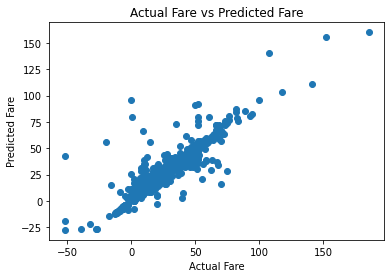

In [33]:
pred_valid = model.predict(dvalid)
score_XGB_valid = metrics.r2_score(pred_valid,Y_valid)
print(f"R2 Score: {score_XGB_valid}")
error_XGB_valid = metrics.mean_squared_error(pred_valid,Y_valid)
print(f"Mean Squared Error: {error_XGB_valid}")
plt.scatter(Y_valid,pred_valid)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual Fare vs Predicted Fare")
plt.show()


In [34]:
pred_test = model.predict(dtest)
test['fare_amount'] = pred_test
test.head()

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,congestion_surcharge,pickup_hour,time,day_of_week_sin,day_of_week_cos,fare_amount
0,1.0,1.66,1.0,0.0,48,90,2.5,18,5.683333,0.974928,-0.222521,7.104831
1,3.0,1.50,1.0,0.0,48,246,2.5,23,7.000000,-0.781831,0.623490,6.977403
2,1.0,1.90,1.0,0.0,237,234,2.5,12,7.166667,0.974928,-0.222521,8.064060
3,1.0,0.27,1.0,0.0,170,170,2.5,9,2.550000,-0.781831,0.623490,3.817357
4,2.0,4.06,1.0,0.0,186,238,2.5,18,16.800000,0.974928,-0.222521,15.286615


## Final Output and creating .csv file

In [35]:
print(f"We get {score_LR_valid * 100:0.2f}% accuracy on Validation set for Linear Regression")
print(f"We get {score_XGB_valid * 100:0.2f}% accuracy on Validation set for XGBoost")

We get 70.20% accuracy on Validation set for Linear Regression
We get 92.36% accuracy on Validation set for XGBoost


In [36]:
data = pd.read_csv('test_data_iitm.csv')
data['fare_amount'] = pred_test
data.to_csv('AE19B019_PIYUSH_BHUJBAL_predictions.csv', index=False)